# Análises COVID-19

> Edneudo Barros

Vamos analisar as séries temporais sobre a contaminação do vírus COVID-19 no município de Icapuí-CE, no nordeste brasileiro.

O primeiro passo é importar as bibliotecas que utilizaremos.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

Agora, vamos importar os dados. Trata-se de dados obtidos no [Painel do Corona Vírus](https://covid.saude.gov.br/), mantido pelo governo federal. Os dados foram obtidos em 20/out/2022 e já passaram por processo simples de ETL, de maneira a constarem apenas as informações referentes ao município Icapuí-CE.

In [33]:
url = 'https://raw.githubusercontent.com/BarrosEdneudo/Covid-Icapui2022/main/CovidIcapui2022.csv'

df = pd.read_csv(url, parse_dates=['data'],sep=';')
df

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2020-03-27,13,19934,0,0,0,0,NaN,NaN,0
1,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2020-03-28,13,19934,0,0,0,0,NaN,NaN,0
2,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2020-03-29,14,19934,0,0,0,0,NaN,NaN,0
3,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2020-03-30,14,19934,0,0,0,0,NaN,NaN,0
4,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2020-03-31,14,19934,0,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2022-10-15,41,19934,4191,0,38,0,NaN,NaN,0
933,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2022-10-16,42,19934,4191,0,38,0,NaN,NaN,0
934,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2022-10-17,42,19934,4191,0,38,0,NaN,NaN,0
935,Nordeste,CE,Icapuí,23,230535,23007,7ª REGIAO ARACATI,2022-10-18,42,19934,4191,0,38,0,NaN,NaN,0


Agora, vamos conferir os tipos das variáveis para verificar que as colunas foram corretamente importadas.

In [34]:
df.dtypes

regiao                            object
estado                            object
municipio                         object
coduf                              int64
codmun                             int64
codRegiaoSaude                     int64
nomeRegiaoSaude                   object
data                      datetime64[ns]
semanaEpi                          int64
populacaoTCU2019                   int64
casosAcumulado                     int64
casosNovos                         int64
obitosAcumulado                    int64
obitosNovos                        int64
Recuperadosnovos                 float64
emAcompanhamentoNovos            float64
interior/metropolitana             int64
dtype: object

In [35]:
# Vamos conferir quantas linhas e colunas temos em nosso dataframe.
df.shape

(937, 17)

## Análises

Show! Agora vamos começar a investigar as variáveis que temos à disposição.

In [36]:
px.line(df, x='data',y='casosAcumulado', title='Casos acumulados em Icapuí-CE',labels={'data':'Data','casosAcumulado': 'Casos acumulados'})

## Número de novos casos por dia

In [37]:
# Vamos implementar uma função para fazer a contagem de novos casos
df['casosNovos'] = list(map(
    lambda x: 0 if (x==0) else df['casosAcumulado'].iloc[x] - df['casosAcumulado'].iloc[x-1],
    np.arange(df.shape[0])
))

In [38]:
# Visualizando
px.line(df, x='data', y='casosNovos', title='Novos casos por dia',
       labels={'data': 'Data', 'casosNovos': 'Novos casos por dia'})

O número de novos casos parece ser um excelente caso para modelagem. Será que conseguimos predizer quando o número de novos casos vai começar a cair?

## Mortes

In [39]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df.casosAcumulado, y=df.obitosAcumulado, name='Mortes', mode='lines+markers',
              line=dict(color='red'))
)
#Editando o layout
fig.update_layout(title='Mortes por COVID-19 em Icapuí-CE',
                   xaxis_title='Data',
                   yaxis_title='Número de mortes')
fig.show()

# Taxa de crescimento

Vamos calcular a taxa de crescimento do COVID desde o primeiro caso.

In [40]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.data.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.data.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.data == data_inicio, variable].values[0]
    presente = data.loc[data.data == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [41]:
cresc_medio = taxa_crescimento(df, 'casosAcumulado')
print(f"O crescimento médio do COVID em Icapuí-CE no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID em Icapuí-CE no período avaliado foi de 0.91%.


Agora, vamos observar o comportamento da **taxa de crescimento no tempo**. Para isso, vamos definir uma função para calcular a taxa de crescimento diária.

In [42]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.data.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
    data_fim = data.data.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x:(data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)*100

In [43]:
tx_dia = taxa_crescimento_diaria(df, 'casosNovos')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in long_scalars



In [44]:
tx_dia

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             inf,
       -1.00000000e+02,             nan,             nan,             nan,
                   nan,             inf,  0.00000000e+00, -3.00000000e+02,
       -1.00000000e+02,             nan,             nan,             nan,
                   nan,             nan,             inf, -1.00000000e+02,
                   inf, -1.00000000e+02,             inf, -1.00000000e+02,
                   nan,             nan,             inf, -1.00000000e+02,
                   nan,             nan,             nan,             inf,
        6.00000000e+02, -1.00000000e+02,            -inf, -1.00000000e+02,
                   inf, -1.00000000e+02,             inf,  1.00000000e+02,
       -5.00000000e+01, -1.00000000e+02,            -inf, -9.00000000e+02,
       -1.00000000e+02,  

In [45]:
primeiro_dia = df.data.loc[df.casosAcumulado > 0].min()
px.line(x=pd.date_range(primeiro_dia, df.casosAcumulado.max())[1:],
        y=tx_dia, title='Taxa de crescimento de casos confirmados em Icapuí-CE',
       labels={'y':'Taxa de crescimento', 'x':'Data'})

# Predições

Vamos construir um modelo de séries temporais para prever os novos casos. Antes analisemos a série temporal.

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

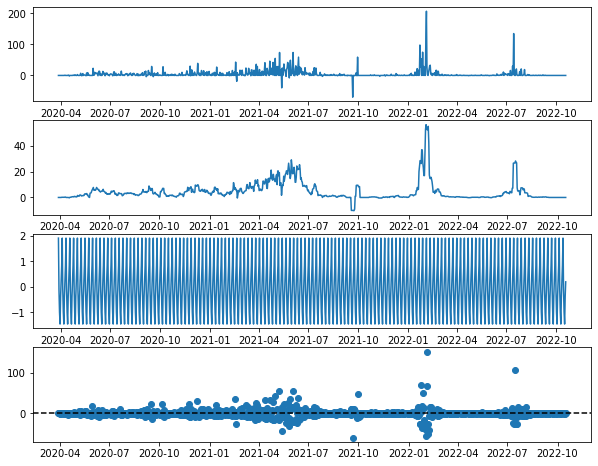

In [47]:
novoscasos = df.casosNovos
novoscasos.index = df.data

res = seasonal_decompose(novoscasos)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

## Decompondo a série de confirmados



In [48]:
confirmados = df.casosAcumulado
confirmados.index = df.data

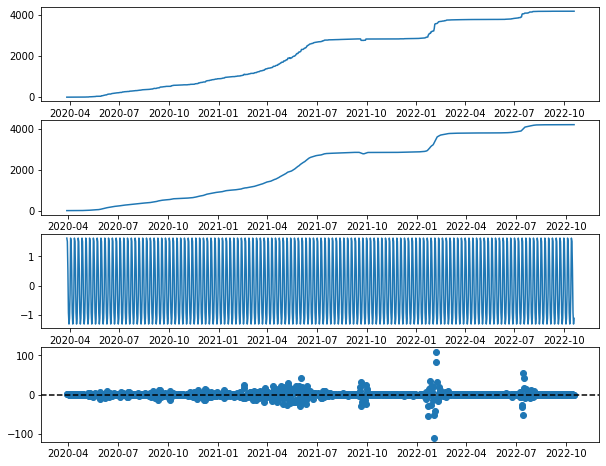

In [49]:
res2 = seasonal_decompose(confirmados)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res2.observed)
ax2.plot(res2.trend)
ax3.plot(res2.seasonal)
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()